In [1]:
import os
import sys
import pandas
import numpy, scipy, sklearn

import findspark
findspark.init("/opt/local/spark/spark")

import pyspark
from pyspark.sql.window import Window
import pyspark.sql.functions as func

from pyspark.rdd import reduce
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
import pyspark.mllib.linalg.distributed
from pyspark.mllib.linalg.distributed import RowMatrix, DenseMatrix
from pyspark.ml.linalg import SparseVector, VectorUDT, Vector, Vectors
from pyspark.mllib.stat import Statistics

In [2]:
from scipy import linalg

In [3]:
random_state = numpy.random.mtrand._rand

In [4]:
conf = pyspark.SparkConf().setMaster("local[*]").set("spark.driver.memory", "4G").set("spark.executor.memory", "4G")
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.sql.SparkSession(sc)

In [9]:
file_name = "/home/simon/PROJECTS/koios//data/iris.tsv"

In [10]:
df = spark.read.csv(path=file_name, sep="\t", header='true')

In [11]:
for i, x in enumerate(df.columns):
    df = df.withColumn(x, df[x].cast("double"))
df = df.fillna(0)

In [12]:
features = df.columns[:4]
features

['slength', 'swidth', 'plength', 'pwidth']

In [13]:
p = 4
n_components = 3

In [15]:
X = df.select(features).rdd.map(numpy.array)

In [17]:
x_mean = Statistics.colStats(X).mean()

In [18]:
X = X.map(lambda x: x - x_mean)

In [19]:
Statistics.colStats(X).mean()

array([ 6.18483129e-16,  1.88846334e-15,  5.95010152e-16, -3.54750951e-16])

In [20]:
X = RowMatrix(X)

In [22]:
svd = X.computeSVD(X.numCols())

In [23]:
s = svd.s.toArray()
V = svd.V.toArray().T

In [42]:
V

array([[-0.36138659,  0.08452251, -0.85667061, -0.3582892 ],
       [-0.65658877, -0.73016143,  0.17337266,  0.07548102],
       [ 0.58202985, -0.59791083, -0.07623608, -0.54583143],
       [ 0.31548719, -0.3197231 , -0.47983899,  0.75365743]])

In [39]:
s

array([25.09996044,  6.01314738,  3.41368064,  1.88452351])

In [24]:
arr = df.select(features).toPandas().values
arr -= arr.mean(axis=0)
u, d, v = linalg.svd(arr, full_matrices=False)

In [64]:
def _exp(x):
    exp = numpy.exp(-(x ** 2) / 2)
    gx = x * exp
    g_x = (1 - x ** 2) * exp
    return gx, g_x.mean(axis=0)

In [66]:
_exp(v)

(array([[ 0.33854199, -0.08422114,  0.59354393,  0.3360147 ],
        [-0.52927254, -0.55930659,  0.17078652,  0.0752663 ],
        [ 0.49134295, -0.50004243, -0.07601486, -0.4702875 ],
        [ 0.30017091, -0.30379219, -0.42765974,  0.56732831]]),
 array([0.67199648, 0.68432859, 0.70430094, 0.68475276]))

In [210]:
def _sym_decorrelation(W):
    s, u = linalg.eigh(numpy.dot(W, W.T))
    return numpy.dot(numpy.dot(u * (1. / numpy.sqrt(s)), u.T), W)

In [45]:
v / d

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [-0.65658877, -0.73016143,  0.17337266,  0.07548102],
       [ 0.58202985, -0.59791083, -0.07623608, -0.54583143],
       [ 0.31548719, -0.3197231 , -0.47983899,  0.75365743]])

In [40]:
d

array([25.09996044,  6.01314738,  3.41368064,  1.88452351])

In [59]:
K = V.T / s * 

In [108]:
V

array([[-0.36138659,  0.08452251, -0.85667061, -0.3582892 ],
       [-0.65658877, -0.73016143,  0.17337266,  0.07548102],
       [ 0.58202985, -0.59791083, -0.07623608, -0.54583143],
       [ 0.31548719, -0.3197231 , -0.47983899,  0.75365743]])

In [109]:
V * V

array([[0.13060027, 0.00714406, 0.73388453, 0.12837115],
       [0.43110881, 0.53313572, 0.03005808, 0.00569738],
       [0.33875875, 0.35749736, 0.00581194, 0.29793195],
       [0.09953217, 0.10222286, 0.23024545, 0.56799951]])

In [111]:
V[1,0] ** 2

0.43110881457996536

In [78]:
K = DenseMatrix(K.shape[0], K.shape[1], K.flatten(), True)

AttributeError: 'DenseMatrix' object has no attribute 'shape'

In [117]:
Kpy

SyntaxError: invalid syntax (<ipython-input-117-990eef2a8305>, line 1)

In [87]:
jj = DenseMatrix(4, 4, scipy.zeros(shape=(4 * 4)))

In [94]:
jj.toArray()

array([[0., 2., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [182]:
X1 = arr.dot(K) * scipy.sqrt(150)

In [106]:
X.multiply(X)

ValueError: Only multiplication with DenseMatrix is supported.

In [184]:
X1[:,0] *= -1

In [97]:
w_init = numpy.asarray(random_state.normal(size=(n_components, n_components)))

In [98]:
w_init

array([[ 2.5444303 ,  0.24360331,  1.0780228 ],
       [-0.45594795, -0.31267847, -0.20475575],
       [-0.56022671,  1.14545159,  1.23978127]])

In [100]:
w = w_init[1, :].copy()
w /= scipy.sqrt((w ** 2).sum())

In [102]:
len(w)

3

In [240]:
W = _sym_decorrelation(w_init)
W

array([[ 0.22075675, -0.32863939, -0.91829331],
       [-0.97442076, -0.11493557, -0.19311652],
       [-0.04207887,  0.93743585, -0.34560585]])

In [241]:
p_ = float(X1.shape[0])

In [242]:
gwtx, g_wtx = _exp(np.dot(X1, W))

In [243]:
kk = gwtx.T.dot(X1) / p_ - g_wtx[:, numpy.newaxis] * W

In [245]:
W1 = _sym_decorrelation(kk)

In [246]:
lim = max(abs(abs(np.diag(np.dot(W1, W.T))) - 1))
W = W1

In [248]:
for ii in range(10):
    gwtx, g_wtx = _exp(np.dot(X1, W))
    kk = gwtx.T.dot(X1) / p_ - g_wtx[:, numpy.newaxis] * W
    W1 = _sym_decorrelation(kk)
    del gwtx, g_wtx
    # builtin max, abs are faster than numpy counter parts.
    lim = max(abs(abs(np.diag(np.dot(W1, W.T))) - 1))
    W = W1

In [252]:
K.shape

(4, 3)

In [ ]:
K1.shae

In [258]:
S = arr.dot(K.dot(W))

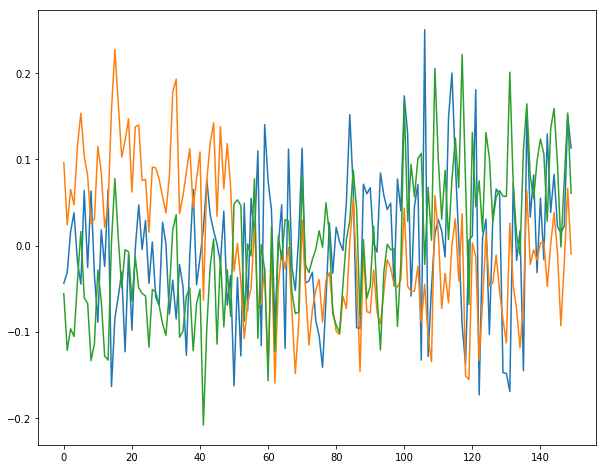

In [260]:
plt.plot(S)

In [81]:
X = df.select(features).rdd.map(np.array)

In [82]:
means = Statistics().colStats(X).mean()

In [83]:
X = X.map(lambda x: (x - means))

In [84]:
X = RowMatrix(X)

In [109]:
svd = X.computeSVD(X.numCols(), computeU=True)
u = svd.U
d = svd.s.toArray()

In [114]:
u.rows.map(lambda x: x / d)

MapPartitionsRDD[87] at mapPartitions at PythonMLLibAPI.scala:1339

In [110]:
K = (u / d).T[:2]

TypeError: unsupported operand type(s) for /: 'RowMatrix' and 'float'

In [383]:
Xm = (df.select(features).rdd.map(list))

In [384]:
targets = df.select("t").distinct() 
targets = targets.toPandas().values.flatten()

In [424]:
type(targets)

numpy.ndarray

In [386]:
summa = Statistics.colStats(Xm)
means_all = summa.mean()

In [387]:
means_t = numpy.zeros((3, 4))

In [388]:
for i, target in enumerate(targets):
    df_t = df.filter("t == {}".format(target))
    X_t = df_t.select(features).rdd.map(list)
    means_t[i, :] =  Statistics.colStats(X_t).mean()
means_t

array([[5.006, 3.428, 1.462, 0.246],
       [5.936, 2.77 , 4.26 , 1.326],
       [6.588, 2.974, 5.552, 2.026]])

In [261]:
numpy.mean(iris.data, axis=0)

array([5.84333333, 3.05733333, 3.758     , 1.19933333])

In [262]:
Xs  = RowMatrix(df.filter("t == {}".format(target)).rdd.map(list))

In [366]:
S_W = numpy.zeros((4, 4))
for target in targets:
    df_t = df.filter("t == {}".format(target))
    X_t = RowMatrix(df_t.select(features).rdd.map(list))
    cov_t = X_t.computeCovariance().toArray() * (df_t.count() - 1)
    S_W += cov_t

In [367]:
S_W

array([[38.9562, 13.63  , 24.6246,  5.645 ],
       [13.63  , 16.962 ,  8.1208,  4.8084],
       [24.6246,  8.1208, 27.2226,  6.2718],
       [ 5.645 ,  4.8084,  6.2718,  6.1566]])

In [368]:
S_B = numpy.zeros((4, 4))
means_all = means_all.reshape(4, 1)
for i, mean_vec in enumerate(means_t):  
    mean_vec = mean_vec.reshape(4, 1)
    n = df.filter("t == {}".format(i)).count()
    S_B += n * (mean_vec - means_all).dot((mean_vec - means_all).T)
S_B

array([[ 63.21213333, -19.95266667, 165.2484    ,  71.27933333],
       [-19.95266667,  11.34493333, -57.2396    , -22.93266667],
       [165.2484    , -57.2396    , 437.1028    , 186.774     ],
       [ 71.27933333, -22.93266667, 186.774     ,  80.41333333]])

In [369]:
SS = RowMatrix(df.select(features).rdd.map(list)).computeCovariance()

In [425]:
S_B = SS.toArray() * df.count() - S_W
S_B

Py4JJavaError: An error occurred while calling o1016.count.
: org.apache.spark.sql.catalyst.errors.package$TreeNodeException: execute, tree:
Exchange SinglePartition
+- *(1) HashAggregate(keys=[], functions=[partial_count(1)], output=[count#1479L])
   +- *(1) FileScan csv [] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/home/simon/PROJECTS/koios/analysis/iris.tsv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<>

	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:56)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.doExecute(ShuffleExchangeExec.scala:119)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:374)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.inputRDDs(HashAggregateExec.scala:151)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:610)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan.getByteArrayRdd(SparkPlan.scala:247)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:296)
	at org.apache.spark.sql.Dataset$$anonfun$count$1.apply(Dataset.scala:2831)
	at org.apache.spark.sql.Dataset$$anonfun$count$1.apply(Dataset.scala:2830)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3365)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3364)
	at org.apache.spark.sql.Dataset.count(Dataset.scala:2830)
	at sun.reflect.GeneratedMethodAccessor75.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.GatewayConnection.run(GatewayConnection.java:238)
java.lang.Thread.run(Thread.java:748)

The currently active SparkContext was created at:

(No active SparkContext.)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:100)
	at org.apache.spark.SparkContext.broadcast(SparkContext.scala:1486)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat.buildReader(CSVFileFormat.scala:103)
	at org.apache.spark.sql.execution.datasources.FileFormat$class.buildReaderWithPartitionValues(FileFormat.scala:129)
	at org.apache.spark.sql.execution.datasources.TextBasedFileFormat.buildReaderWithPartitionValues(FileFormat.scala:165)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD$lzycompute(DataSourceScanExec.scala:312)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD(DataSourceScanExec.scala:310)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDDs(DataSourceScanExec.scala:330)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.inputRDDs(HashAggregateExec.scala:151)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:610)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.prepareShuffleDependency(ShuffleExchangeExec.scala:92)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$doExecute$1.apply(ShuffleExchangeExec.scala:128)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$doExecute$1.apply(ShuffleExchangeExec.scala:119)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	... 36 more


In [457]:
eig_vals, eig_vecs = numpy.linalg.eig(numpy.linalg.inv(S_W).dot(S_B))

In [458]:
eig_vals

array([3.24146938e+01, 2.94017828e-01, 6.71140940e-03, 6.71140940e-03])

In [446]:
idx = numpy.argsort(-abs(eig_vals))

In [456]:
eig_vals

array([3.24146938e+01, 2.94017828e-01, 6.71140940e-03, 6.71140940e-03])

In [451]:
eig_vecs[:,idx]

array([[-0.20874182,  0.00653196, -0.05756863,  0.6263798 ],
       [-0.38620369,  0.58661055, -0.3169543 , -0.44389328],
       [ 0.55401172, -0.25256154, -0.38861031, -0.47751839],
       [ 0.7073504 ,  0.76945309,  0.86325422,  0.42729766]])

In [372]:
import numpy as np

In [459]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

32.41469382377064
0.2940178281440469
0.006711409395977925
0.006711409395636486


In [460]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))


Variance explained:

eigenvalue 1: 99.06%
eigenvalue 2: 0.90%
eigenvalue 3: 0.02%
eigenvalue 4: 0.02%


In [442]:
eig_vecs = eig_vecs.T

In [455]:
eig_vecs

array([[-0.20874182,  0.00653196,  0.6263798 , -0.05756863],
       [-0.38620369,  0.58661055, -0.44389328, -0.3169543 ],
       [ 0.55401172, -0.25256154, -0.47751839, -0.38861031],
       [ 0.7073504 ,  0.76945309,  0.42729766,  0.86325422]])

In [454]:
eig_vals

array([3.24146938e+01, 2.94017828e-01, 6.71140940e-03, 6.71140940e-03])

In [461]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

In [377]:
tmp_dense = DenseMatrix(numRows=W.shape[0], numCols=W.shape[1], values=W.flatten())
X_lda = RowMatrix(df.select(features).rdd.map(list)).multiply(tmp_dense)

In [378]:
XL = spark.createDataFrame(X_lda.rows.map(lambda x: (x,))).toPandas()

In [379]:
YM = iris.data.dot(W)

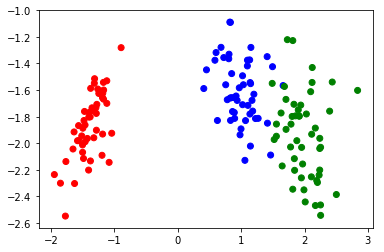

In [380]:
plt.scatter(YM[:,0],-1*YM[: ,1], color=[["red", "blue", "green"][x] for x in y])

In [391]:
iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names



In [399]:
t = timeit.Timer('char in text', setup='text = "sample string"; char = "g"')

In [403]:
import time

In [420]:
d = time.time()
lda = LinearDiscriminantAnalysis(n_components=2, solver='svd')
_ = lda.fit_transform(X, y)
print(time.time() - d)

0.0049397945404052734


In [419]:
d = time.time()
lda = LinearDiscriminantAnalysis(n_components=2, solver='eigen')
_ = lda.fit_transform(X, y)
print(time.time() - d)

0.003131389617919922


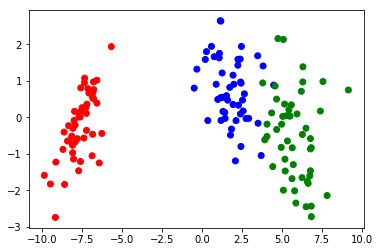

In [382]:
plt.scatter(-1*s[:,0], -1*s[: ,1], color=[["red", "blue", "green"][x] for x in y])

In [243]:
W

array([[-0.20874182, -0.00653196],
       [-0.38620369, -0.58661055],
       [ 0.55401172,  0.25256154],
       [ 0.7073504 , -0.76945309]])

In [261]:
spark.stop()

In [14]:
fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10, 8]

In [16]:
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

In [21]:
colors = ['red', 'steelblue', 'orange']